# Coupling
This notebook investigates coupled motion using transfer matrices.

## Setup 

In [65]:
import sys
import numpy as np
import numpy.linalg as la
import matplotlib
from matplotlib import pyplot as plt, animation, lines
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys')
from tools import (
    plotting as myplt,
    animation as myanim,
    envelope_analysis as ea,
    coupling as BL,
    matrix_lattice,
    utils)
from tools.envelope_analysis import Envelope
from tools.matrix_lattice import MatrixLattice, fodo
from tools.utils import show, play

In [66]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # `None` for default proplot style
plot.rc['savefig.dpi'] = 'figure' # proplot default is 1200, which makes inline animations appear huge

## Create lattice 

In [67]:
L = 5.0
k1, k2 = 0.1, 0.1
lattice = fodo(k1, k2, L, fill_fac=0.5, quad_tilt=1, start='quad')

In [68]:
show(lattice.M, 'M', dec=3)
print()
lattice.print_params('2D')
print()
lattice.print_params('4D')

M =
⎡0.968   5.578  0.024   0.033⎤
⎢                            ⎥
⎢-0.011  0.968  0.009   0.019⎥
⎢                            ⎥
⎢0.019   0.033  0.968   4.407⎥
⎢                            ⎥
⎣0.009   0.024  -0.014  0.968⎦

2D lattice parameters
---------------------
mux = 14.63
muy = 14.63
nux = 0.04
nuy = 0.04
bx = 22.08
by = 17.45
ax = 0.00
ay = -0.00

4D lattice parameters
---------------------
a1x = -0.00
a1y = -0.00
a2x = 0.00
a2y = -0.00
b1x = 8.54
b1y = 6.75
b2x = 19.16
b2y = 15.14
u = 0.50
nu1 = -0.00
nu2 = -0.00
mu1 = 18.93
mu2 = 8.43


## Eigenvalues and eigenvectors 

Below the four eigenvalues are plotted in the complex plane. The eigenvalues will lie on the unit circle if the lattice is stable.

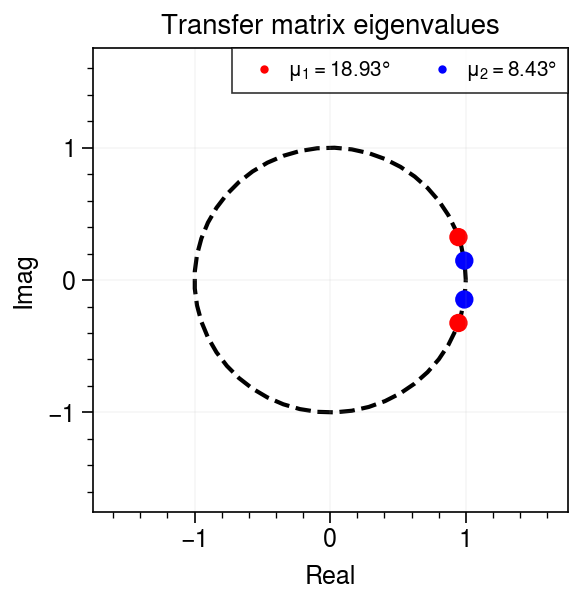

In [69]:
fig, ax = plot.subplots(figsize=(2.9, 3))
myplt.eigvals_complex_plane(ax, lattice.eigvals)
ax.set_title('Transfer matrix eigenvalues')
plt.savefig('eigvals.png', dpi=500, facecolor='white')

Track a particle which is a linear combination of the eigenvectors, i.e.:
$$
\mathbf{x} = Re \left[ \sqrt{\varepsilon_1}\mathbf{v}_1 e^{i\psi_1} + \sqrt{\varepsilon_2}\mathbf{v}_2 e^{i\psi_2} \right],
$$
where $\mathbf{v}_l$ are the eigenvectors, $\psi_l$ are initial phases, and $\varepsilon_l$ are initial amplitudes.

In [70]:
nturns = 10000
eps1 = 45 # [mm-mrad]
eps2 = 5 # [mm-mrad]
psi1 = 0 # initial phase of eigenvector 1
psi2 = np.radians(90) # initial phase of eigenvector 2
norm_coords = False

In [71]:
# Form coordinate vector
x1 = np.real(np.sqrt(eps1) * lattice.v1 * np.exp(1j*psi1)) # mode 1 contribution
x2 = np.real(np.sqrt(eps2) * lattice.v2 * np.exp(1j*psi2)) # mode 2 contribution
x = x1 + x2

# Track
X1 = lattice.track_part(x1, nturns, norm_coords=norm_coords)
X2 = lattice.track_part(x2, nturns, norm_coords=norm_coords)
X = lattice.track_part(x, nturns, norm_coords=norm_coords)

Relate the 4D Twiss parameters from the transfer matrix to the ellipses traced out by the eigenvectors in the $x$-$x{'}$ and $y$-$y{'}$ planes. The twiss parameters $\beta_{1x}$ and $\alpha_{1x}$ correspond to the ellipse traced by $\mathbf{v}_1$ in the $x$-$x{'}$ plane, while $\beta_{2x}$ and $\alpha_{2x}$ correspond to the ellipse traced by $\mathbf{v}_2$ in the $x$-$x{'}$ plane. The only complication is that they are defined by the ellipse dimensions divided by $\varepsilon_1$. The actual area of the ellipse traced by $\mathbf{v}_1$ in the $x$-$x{'}$ plane is given by $|1 - u| \varepsilon_1$, while in the $y$-$y{'}$ plane it is given by $|u| \varepsilon_2$. The actual area of the ellipse traced by $\mathbf{v}_2$ in the $x$-$x{'}$ plane is given by $|u| \varepsilon_1$, while in the $y$-$y{'}$ plane it is given by $|1-u| \varepsilon_2$.

In [72]:
def emittance_x(X):
    imax_x, imax_xp, imax_y, imax_yp = np.argmax(X, axis=0)
    izero_x, izero_xp, izero_y, izero_yp = np.argmin(np.abs(X), axis=0)
    a, b = np.abs(X[izero_xp, :2])
    c, d = np.abs(X[imax_x, :2])
    e, f = np.abs(X[imax_xp, :2])
    g, h = np.abs(X[izero_x, :2])
    alpha = -e / h
    beta = (a / h) * np.sqrt(1 + alpha**2)
    eps = c**2 / beta
    return eps

def emittance_y(X):
    imax_x, imax_xp, imax_y, imax_yp = np.argmax(X, axis=0)
    izero_x, izero_xp, izero_y, izero_yp = np.argmin(np.abs(X), axis=0)
    a, b = np.abs(X[izero_yp, 2:])
    c, d = np.abs(X[imax_y, 2:])
    e, f = np.abs(X[imax_yp, 2:])
    g, h = np.abs(X[izero_y, 2:])
    alpha = -e / h
    beta = (a / h) * np.sqrt(1 + alpha**2)
    eps = c**2 / beta
    return eps

In [73]:
xmax1, xpmax1, ymax1, ypmax1 = np.max(X1, axis=0)
xmax2, xpmax2, ymax2, ypmax2 = np.max(X2, axis=0)
u = lattice.params4D['u']

print("x-x' plane")
print('--------------------------')
print('xmax1 / eps1 = {:.3f}'.format(xmax1**2 / eps1))
print('beta_1x: = {:.3f}'.format(lattice.params4D['b1x']))
print()
print('xmax2 / eps2 = {:.3f}'.format(xmax2**2 / eps2))
print('beta_2x: = {:.3f}'.format(lattice.params4D['b2x']))
print()
print("Emittance traced by v1 = {:.3f}".format(emittance_x(X1)))
print('eps1 * abs(1 - u)  = {:.3f}'.format(eps1 * np.abs(1 - u)))
print()
print("Emittance traced by v2 = {:.3f}".format(emittance_x(X2)))
print('eps2 * abs(u)  = {:.3f}'.format(eps2 * np.abs(u)))
print()
print()
print("y-y' plane")
print('--------------------------')
print('ymax1 / eps1 = {:.3f}'.format(ymax1**2 / eps1))
print('beta_1y: = {:.3f}'.format(lattice.params4D['b1y']))
print()
print('ymax2 / eps2 = {:.3f}'.format(ymax2**2 / eps2))
print('beta_2y: = {:.3f}'.format(lattice.params4D['b2y']))
print()
print("Emittance traced by v1 = {:.3f}".format(emittance_y(X1)))
print('eps1 * abs(u)  = {:.3f}'.format(eps1 * np.abs(u)))
print()
print("Emittance traced by v2 = {:.3f}".format(emittance_y(X2)))
print('eps2 * abs(1 - u)  = {:.3f}'.format(eps2 * np.abs(1 - u)))
print()

x-x' plane
--------------------------
xmax1 / eps1 = 8.543
beta_1x: = 8.543

xmax2 / eps2 = 19.157
beta_2x: = 19.157

Emittance traced by v1 = 22.503
eps1 * abs(1 - u)  = 22.503

Emittance traced by v2 = 2.500
eps2 * abs(u)  = 2.500


y-y' plane
--------------------------
ymax1 / eps1 = 6.748
beta_1y: = 6.748

ymax2 / eps2 = 15.141
beta_2y: = 15.141

Emittance traced by v1 = 22.490
eps1 * abs(u)  = 22.497

Emittance traced by v2 = 2.500
eps2 * abs(1 - u)  = 2.500



Plot the trajectory in the $x$-$x'$ plane, along with the ellipse for each eigenvector.

In [74]:
def plot_ellipses(X1, X2, dim='x', plt_vectors=False):
    
    # Get coordinates at maximum horizontal extent of first ellipse.
    # This will be the location of the second ellipse.
    if dim == 'x':
        i, j = 0, 1
    elif dim == 'y':
        i, j = 2, 3
    imax = np.argmax(X1, axis=0)
    coords_at_umax = X1[imax[i]]
    umax, up_at_umax = coords_at_umax[[i, j]]
    
    # Plot ellipses
    fig, ax = plt.subplots(figsize=(4, 4), tight_layout=True)
    myplt.despine([ax], 'all')
    lw = 1
    alpha = 1
    ax.plot(X1[:, i], X1[:, j], color='r', alpha=alpha, lw=lw)
    ax.plot(umax + X2[:, i], up_at_umax + X2[:, j], lw=lw, color='b', alpha=alpha)
    ax.scatter(X[:, i], X[:, j], s=1, c='k', alpha=0.2, ec='none')
    
    # Draw x and y axis
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    myplt.vector(ax, [sum([abs(x) for x in xlim]), 0], origin=[xlim[0], 0], lw=1)
    myplt.vector(ax, [0, sum([abs(y) for y in ylim])], origin=[0, ylim[0]], lw=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if dim == 'x':
        labels = [r"$x$", r"$p_x$"]
    elif dim == 'y':
        labels = [r"$y$", r"$p_y$"]
    ax.annotate(labels[0], xy=(1.02, 0.48), xycoords='axes fraction', fontsize='x-large')
    ax.annotate(labels[1], xy=(0.45, 1.02), xycoords='axes fraction', fontsize='x-large')
    if plt_vectors:
        myplt.vector(ax, coords_at_xmax1[[0, 1]], c='r')
        myplt.vector(ax, coords_at_xmax2[[0, 1]], origin=coords_at_xmax1[[0, 1]], c='b')
    return ax

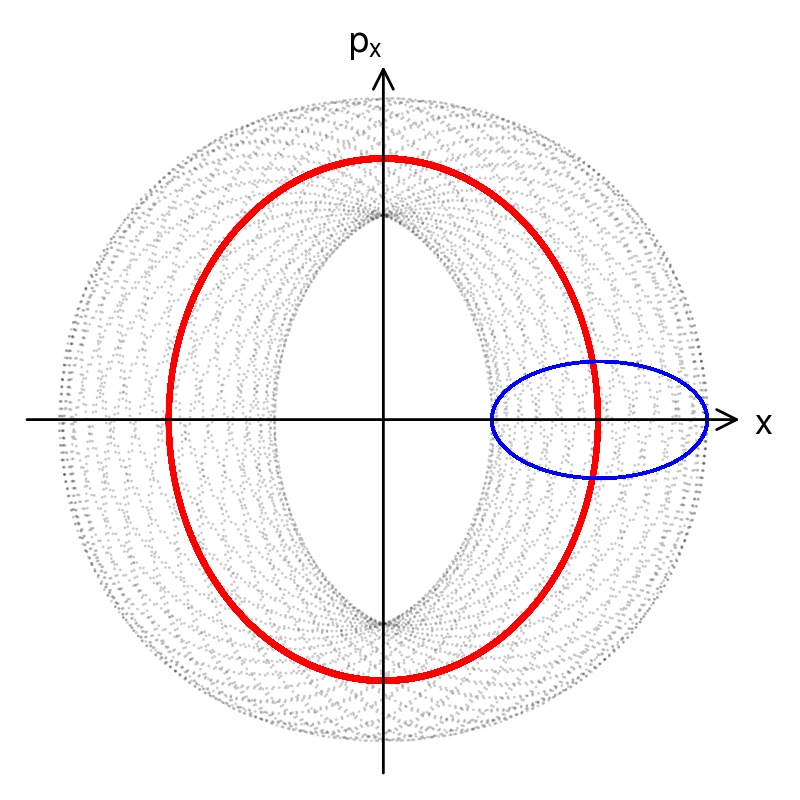

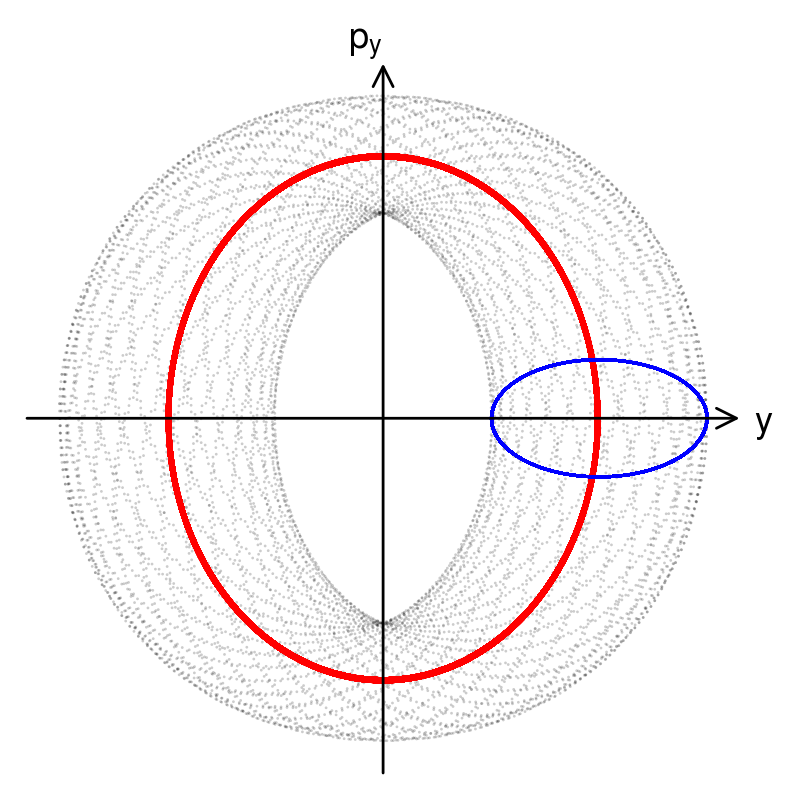

In [75]:
for dim in ['x','y']:
    ax = plot_ellipses(X1, X2, dim, plt_vectors=False) 
    plt.savefig('ellipse_{}.png'.format(dim), dpi=500, facecolor='w')

In [76]:
periods = 100

anim = myanim.corner_onepart(
    X[:periods], 
    vecs=[X1[:periods], X2[:periods]], 
    text_fmt='Period = {}', 
    grid=False, 
    norm_labels=norm_coords, 
    units='mm-mrad',
    fps=10, 
    show_history=False,
#     figname='eigvecs.mp4', dpi=900,
    s=5)
play(anim)

## Matched beam condition
A turn-by-turn particle trajectory will lie on a closed surface in phase space, and a matched beam is formed by distributing particles uniformly over this surface. The shape of the matched beam will be elliptical if is composed of a single eigenvector, which rotates at a single frequency in every projected plane, or if the eigentunes are equal, since the linear combination of two eigenvectors with the same eigenvalue is also an eigenvector.

In [77]:
# X = lattice.matched_dist(1000, 'gaussian')
# coords = lattice.track_bunch(X, nturns=10)
# play(myanim.corner(coords, text_fmt='Turn = {}'))